In [656]:
#includes
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import numpy as np
from numpy.linalg import norm
from itertools import combinations
import os
import math
from collections import deque
from scipy.spatial import distance as dist

In [580]:
#files
SETS = [('set0', 6),
        ('set1', 20),
        ('set2', 20),
        ('set3', 20),
        ('set4', 20),
        ('set5', 200),
        ('set6', 200),
        ('set7', 20),
        ('set8', 100)]

def get_file_path(set_id, img_id):
    DATA_FOLDER = 'data'
    EXTENSION = '.png'
    return os.path.join(DATA_FOLDER, SETS[set_id][0], str(img_id) + EXTENSION)

get_file_path(0, 1)

'data/set0/1.png'

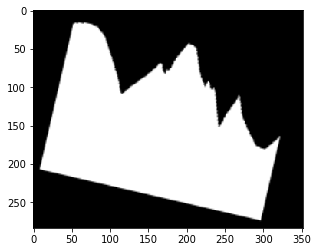

In [678]:
# helpers
def load_file(path: str):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img

def show_img(img, as_gray=False, name='fe.pdf'):
    fig, ax = plt.subplots()
    if as_gray:
        ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
        fig.savefig(name)
    else:
        ax.imshow(img, interpolation='nearest')
        fig.savefig(name)

img = load_file(get_file_path(0,1))
show_img(img, True)

In [693]:
def order_points(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
 
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
 

    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
 

    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
 

    return np.array([tl, tr, br, bl], dtype="float32")

def four_point_transform(image, pts):
    (tl, tr, br, bl) = pts
 
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
 
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
 
    M = cv2.getPerspectiveTransform(pts, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def angle_between_points( p0, p1, p2 ):
    a = (p1[0]-p0[0])**2 + (p1[1]-p0[1])**2
    b = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
    c = (p2[0]-p0[0])**2 + (p2[1]-p0[1])**2
    res = math.acos( (a+b-c) / math.sqrt(4*a*b) ) * 180/np.pi
    return res
    
def check_line_with_mask(mask, p1, p2):
    line_mask = np.zeros_like(mask)
    cv2.line(line_mask, p1, p2, 255, 2)
#     show_img(mask, True)
#     show_img(line_mask, True)
#     show_img(np.logical_and(line_mask, mask), True)
    res = (np.sum(line_mask != 0) - np.sum(np.logical_and(line_mask, mask)  != 0)) / np.sum(line_mask != 0)
#     print(res,np.sum(line_mask != 0), np.sum(np.logical_and(line_mask, mask)  != 0))
    return res
    
def are_the_same(p1, p2):
    return p1[0] == p2[0] and p1[1] == p2[1]
    
def calc_a_and_b(p1, p2):
    a = p1 - p2
    if a[0] == 0.:
        return math.inf, 0
    a = a[1]/a[0]
    return a, p1[1] - a*p1[0]

def max_points(a, b, img, p):
    line_points = set()
    if math.isinf(a):
        line_points = set([(p[0], img.shape[0]-1), (p[0], 0)])
    elif a == 0.:
        line_points = set([(0, int(b)), (img.shape[1]-1, int(b))])
    else:
        if 0 <= b < img.shape[0]: #y range
            line_points.add((0, int(b)))
        if 0 <= int(-b/a) < img.shape[1]: #x range
            line_points.add((int(-b/a), 0))
        if 0 <= int((img.shape[0]-1-b)/a) < img.shape[1]: #x range
            line_points.add((int((img.shape[0]-1-b)/a), img.shape[0]-1))
        if 0 <= int(a* (img.shape[1]-1) + b) < img.shape[0]: #y range
            line_points.add((img.shape[1]-1, int(a* (img.shape[1]-1) + b)))
    
    if len(line_points) > 2:
        line_points = max(combinations(line_points, 2), key=lambda k: cv2.norm(np.array(k[0]) - np.array(k[1])))
            
    return list(line_points)

def line_intersect(p1, p2, p3, p4):
    if p2[0] == p1[0]:
        a, b = calc_a_and_b(np.array(p3), np.array(p4))
        return (p2[0], int(p2[0] * a + b))
    elif p3[0] == p4[0]:
        a, b = calc_a_and_b(np.array(p1), np.array(p2))
        return (p3[0], int(p3[0] * a + b))
    
    Ax = p1[0]
    Ay = p1[1]
    Bx = p2[0]
    By = p2[1]
    Cx = p3[0]
    Cy = p3[1]
    Dx = p4[0]
    Dy = p4[1]
    
    x=((Bx-Ax)*(Dx*Cy-Dy*Cx)-(Dx-Cx)*(Bx*Ay-By*Ax))/((By-Ay)*(Dx-Cx)-(Dy-Cy)*(Bx-Ax))

    y=((Dy-Cy)*(Bx*Ay-By*Ax)-(By-Ay)*(Dx*Cy-Dy*Cx))/((Dy-Cy)*(Bx-Ax)-(By-Ay)*(Dx-Cx))
    return (int(x), int(y))

def destroy_perspective(img):
    _, thresh = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY)
    
    res = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    res[:,:,:] = 0
    mask = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
    
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key = cv2.contourArea)
    cv2.drawContours(res,[cnt],0, (0,255,0), 2)
    
    hull = cv2.convexHull(cnt)
    cv2.drawContours(res,[hull], 0, (255,255,0), 2)    
    cv2.drawContours(mask,[cnt], 0, 255, 5)
    
    epsilon = 0.005*cv2.arcLength(hull,True)
    approx = cv2.approxPolyDP(hull,epsilon,True)
    
    angles = {tuple(approx[point_id][0]): ((approx[point_id-1][0], approx[(point_id+1) % len(approx)][0]), angle_between_points(approx[point_id-1][0], approx[point_id][0], approx[(point_id+1) % len(approx)][0])) for point_id in range(len(approx))}
    lines = [[(p1[0], p2[0]), cv2.norm(p2[0] - p1[0])] for p1, p2 in zip(approx[:-1], approx[1:])]
    lines.append([(approx[0][0], approx[-1][0]), cv2.norm(approx[0][0] - approx[-1][0])])
    
    longest = max(lines, key=lambda d: d[1])[1]
    bottom = min(lines, key=lambda d: 0.25 * check_line_with_mask(mask, tuple(d[0][0]), tuple(d[0][1])) + 0.25 * (longest - d[1])/longest + 0.25 * abs(90 - angles[tuple(d[0][0])][1])/90 + 0.25 * abs(90 - angles[tuple(d[0][1])][1])/90)
#     cv2.drawContours(res,[approx],0,(255,0,255),2)
    
    max_point = max(approx, key=lambda d: norm(np.cross(bottom[0][1]-bottom[0][0], bottom[0][0]-d[0]))/norm(bottom[0][1]-bottom[0][0]))[0]
    bottom_a, bottom_b = calc_a_and_b(bottom[0][0], bottom[0][1])
    line_b = max_point[1] - bottom_a*max_point[0]
    if bottom_a > 0 and line_b > bottom_b:
        bottom[0] = (bottom[0][1], bottom[0][0])
    
    other_neighbor = angles[tuple(bottom[0][0])][0][0] if not are_the_same(angles[tuple(bottom[0][0])][0][0],  bottom[0][1]) else angles[tuple(bottom[0][0])][0][1]
    other_neighbor2 = angles[tuple(bottom[0][1])][0][0] if not are_the_same(angles[tuple(bottom[0][1])][0][0], bottom[0][0]) else angles[tuple(bottom[0][1])][0][1]
    
    side_a, side_b = calc_a_and_b(other_neighbor, bottom[0][0])
    side2_a, side2_b = calc_a_and_b(other_neighbor2, bottom[0][1])
    side_points = max_points(side_a, side_b, res, other_neighbor)
    side2_points = max_points(side2_a, side2_b, res, other_neighbor2)
    print(bottom_a, bottom_b, line_b)
 
    line_points = max_points(bottom_a, line_b, res, max_point)
    point1 = line_intersect(*side_points, *line_points)
    point2 = line_intersect(*side2_points, *line_points)
    
    ar = np.array([np.array(point2), np.array(point1), bottom[0][0], bottom[0][1]]).astype('float32')
    
    
#     cv2.line(res, tuple(bottom[0][0]), tuple(bottom[0][1]), (0,0,255), 2)
#     cv2.line(res, tuple(bottom[0][0]), tuple(other_neighbor), (255,0,0), 2)    
#     cv2.line(res, tuple(bottom[0][1]), tuple(other_neighbor2), (255,0,0), 2)
    
#     cv2.line(res, line_points[0], line_points[1], (0,125,255), 3)
    
#     for r in approx:    
#         cv2.circle(res, tuple(r[0]), 8, (255,0,0), -1)
#     cv2.circle(res, tuple(max_point), 8, (0,125,255), -1)
    
#     cv2.circle(res, line_points[0], 8, (0,0,255), -1)
    
#     cv2.circle(res, line_points[1], 8, (0,0,255), -1)
    
#     cv2.circle(res, side_points[0], 8, (255,0,0), -1)
#     cv2.circle(res, side_points[1], 8, (255,0,0), -1)
#     cv2.line(res, side_points[0], side_points[1], (255,0,0), 3)
#     cv2.circle(res, side2_points[0], 8, (255,0,0), -1)
#     cv2.circle(res, side2_points[1], 8, (255,0,0), -1)
#     cv2.line(res, side2_points[0], side2_points[1], (255,0,0), 3)
    

#     cv2.circle(res, point1, 10, (255,100,100), -1)
#     cv2.circle(res, point2, 8, (255,100,100), -1)
#     cv2.circle(res, tuple(bottom[0][0]), 10, (255,100,100), -1)
#     cv2.circle(res, tuple(bottom[0][1]), 10, (255,100,100), -1)
    
    show_img(res, False, 'in_progress.pdf')
    
    points = np.array([np.array(point2), np.array(point1), bottom[0][0], bottom[0][1]]).astype('float32')
    points = deque(order_points(points))
    up_points = set([point1, point2])
    
    for _ in range(4):
        if tuple(points[0]) in up_points and tuple(points[1]) in up_points:
            break
        points.rotate(1)
    
    return np.array(points)
   

0.4708249496981891 -12.098591549295747 189.50905432595573


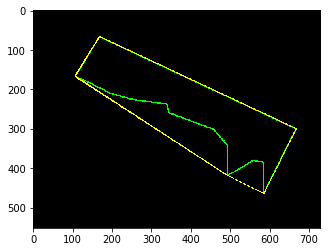

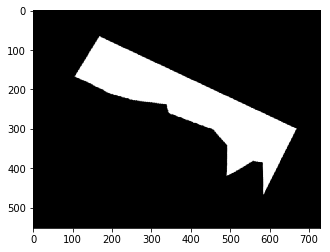

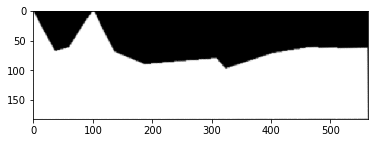

In [694]:
#Testing
for set_id in range(1):
    set_id = 7
    for image_id in range(min(SETS[set_id][1], 1)):
        image_id = 10
        img = load_file(get_file_path(set_id,image_id))
        res = destroy_perspective(img)
        show_img(img, True, 'init.pdf')
        show_img(four_point_transform(img, res), True, 'fin.pdf')
#         set_id = 0
#         image_id = 4
#         img = load_file(get_file_path(set_id,image_id))
#         res = destroy_perspective(img)
#         show_img(img, True)
#         show_img(four_point_transform(img, res), True)
#         image_id = 3
#         img = load_file(get_file_path(set_id,image_id))
#         res = destroy_perspective(img)
#         show_img(img, True)
#         show_img(four_point_transform(img, res), True)
#         image_id = 6
#         img = load_file(get_file_path(set_id,image_id))
#         res = destroy_perspective(img)
#         show_img(img, True)
#         show_img(four_point_transform(img, res), True)
#         image_id = 7
#         img = load_file(get_file_path(set_id,image_id))
#         res = destroy_perspective(img)
#         show_img(img, True)
#         show_img(four_point_transform(img, res), True)